In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
import xml.etree.cElementTree as ET
import ast
from tqdm import tqdm


import argparse
import multiprocessing
import os
import sys

import cv2
import numpy
import tensorflow as tf



import os
import numpy
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras import utils
import xml

#os.chdir('../')

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [4]:

os.listdir()


['.ipynb_checkpoints',
 'greatbarrierreef',
 'input',
 'no-barrier (5).ipynb',
 'tensorflow-great-barrier-reef.zip',
 'working']

In [5]:
train_csv= pd.read_csv('./input/tensorflow-great-barrier-reef/train.csv')
test_csv= pd.read_csv('./input/tensorflow-great-barrier-reef/test.csv')

In [6]:

images= glob.glob("./input/tensorflow-great-barrier-reef/train_images/*/*.jpg")

In [7]:
#images= glob.glob("D:/deep_learning/kaggle_barrier_reef_starfish_detection/working/data_dir/yolo/images_all/*.jpg")

In [8]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
def return_image(path):
    image= cv2.imread(path)
    im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return im_rgb

def draw_bbox(x,y,w,h, im):
    roi=im[y:y+h,x:x+w]
    #cv2.imwrite(str(idx) + '.jpg', roi)
    return cv2.rectangle(im,(x,y),(x+w,y+h),(200,0,0),2)
    

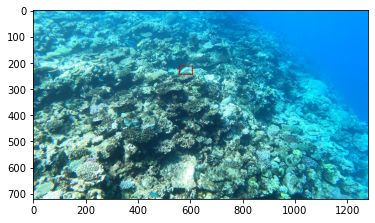

In [10]:
#video 0 16 frame annotations [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]
image_check= return_image('./input/tensorflow-great-barrier-reef/train_images/video_0/16.jpg')
plt.imshow(image_check)
boxed_image= draw_bbox(559,213,50,32,image_check)
plt.imshow(boxed_image)

In [11]:
#Make annotations directory
path_data_dir= './working/data_dir'
if not os.path.exists(path_data_dir):
    os.mkdir(path_data_dir)
labels_path = os.path.join(path_data_dir, 'voc_labels')
if not os.path.exists(labels_path):
    os.mkdir(labels_path)
yolo_ds_path = os.path.join(path_data_dir, 'yolo')
if not os.path.exists(yolo_ds_path):
    os.mkdir(yolo_ds_path)
yolo_ds_labels_path = os.path.join(yolo_ds_path, 'labels_all')
if not os.path.exists(yolo_ds_labels_path):
    os.mkdir(yolo_ds_labels_path)
yolo_ds_images_labels_path = os.path.join(yolo_ds_path, 'images_all')
if not os.path.exists(yolo_ds_images_labels_path):
    os.mkdir(yolo_ds_images_labels_path)    

In [12]:
path_train_txt=os.path.join(path_data_dir,'train.txt')
path_test_txt=os.path.join(path_data_dir,'test.txt')

In [13]:
train_csv.head(5)

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []

In [14]:
os.listdir('./')

['.ipynb_checkpoints',
 'greatbarrierreef',
 'input',
 'no-barrier (5).ipynb',
 'tensorflow-great-barrier-reef.zip',
 'working']

In [15]:
def normalized_yolov5(xmin,ymin,width,height,im_width,im_height):
    x_center= (xmin+xmin+width)/2
    y_center= (ymin+ymin+height)/2
    x_center_normalized= x_center/im_width
    y_center_normalized= y_center/im_height
    width_normalized= width/im_width
    height_normalized= height/im_height
    return x_center_normalized,y_center_normalized,width_normalized,height_normalized

In [16]:
#%cd ../kaggle

In [17]:

from PIL import Image


**We will start with inspection of data**


In [37]:
#************************PREPROCESSING FOR SEA UNDER *******************************
path_yolo_images_preprocessed= './working/data_dir/yolo/images_preprocessed'


In [18]:
yolo_images_paths_with_bbox=[]
yolo_images_bbox_xminmax=[]
yolo_images_bbox_xycenter=[]
targets=[]

In [19]:
df_non_empty_annotation_dict= {}
df_non_empty_annotation_dict['image_paths']=[]
df_non_empty_annotation_dict['video_id']=[]
df_non_empty_annotation_dict['sequence']=[]

In [28]:
#os.remove(path_train_txt)
import PIL
from PIL import Image
import shutil
training_txt = open(path_train_txt,"w")
num_objects_and_paths={}
for index,frame_annotations in tqdm(enumerate(train_csv.annotations.apply(ast.literal_eval))):
    path_image='./input/tensorflow-great-barrier-reef/train_images/video_{}/{}.jpg'.format(train_csv.video_id[index],train_csv.video_frame[index])
    im = Image.open(path_image)
    #src_dir = "your/source/dir"
    #dst_dir = "your/dest/dir"
    bbox_list_minmax=[]
    bbox_list_xycenter=[]
    width_image, height_image = im.size
    #print(len(frame_annotations))
    if len(list(frame_annotations))!=0:
        shutil.copy(path_image,os.path.join(yolo_ds_images_labels_path,"video_{}_{}.jpg".format(train_csv.video_id[index],train_csv.video_frame[index])))
        yolo_images_paths_with_bbox.append(os.path.join(yolo_ds_images_labels_path,"video_{}_{}.jpg".format(train_csv.video_id[index],train_csv.video_frame[index])))
        df_non_empty_annotation_dict['image_paths'].append(os.path.join(path_yolo_images_preprocessed,"video_{}_{}.jpg".format(train_csv.video_id[index],train_csv.video_frame[index])))
        df_non_empty_annotation_dict['video_id'].append(train_csv.video_id[index])
        df_non_empty_annotation_dict['sequence'].append(train_csv.sequence[index])
        #print(frame_annotations)
        txt_file= open(os.path.join(yolo_ds_labels_path,"video_{}_{}.txt".format(train_csv.video_id[index],train_csv.video_frame[index])),'w')
        annotation = ET.Element("annotation")
        ET.SubElement(annotation,"folder").text = "video_{}".format(train_csv.video_id[index])
        ET.SubElement(annotation,"filename").text = "{}.jpg".format(train_csv.video_frame[index])
        ET.SubElement(annotation,"path").text = "../../input/tensorflow-great-barrier-reef/train_images/video_{}/{}.jpg".format(train_csv.video_id[index],train_csv.video_frame[index])
        training_txt.write("video_{}_{}".format(train_csv.video_id[index],train_csv.video_frame[index])+"\n")
        num_annotation=0
        #print("List is not empty")
        for bbox in frame_annotations:
            num_annotation+=1
            object_ann = ET.SubElement(annotation,"object")
            #print(bbox)
            xmin= bbox['x']
            ymin= bbox['y']
            xmax= xmin+bbox['width']
            ymax= ymin+bbox['height']
            #print(xmin)
            bbox_list_minmax.append([xmin,ymin,bbox['width'],bbox['height']])
            x_center_normalized,y_center_normalized,width_normalized,height_normalized=normalized_yolov5(xmin,ymin,bbox['width'],bbox['height'],width_image, height_image)
            bbox_list_xycenter.append([x_center_normalized,y_center_normalized,width_normalized,height_normalized])
            
            in_str= '0 '+ str(x_center_normalized)+' '+ str(y_center_normalized)+' '+ str(width_normalized)+' '+ str(height_normalized)+'\n'
            #print(in_str)
            txt_file.write(in_str)
            ET.SubElement(object_ann, "name").text = "thorn_starfish"
            bbox= ET.SubElement(object_ann, "bndbox")
            ET.SubElement(bbox, "xmin").text = str(xmin)
            ET.SubElement(bbox, "ymin").text = str(ymin)
            ET.SubElement(bbox, "xmax").text = str(xmax)
            ET.SubElement(bbox, "ymax").text = str(ymax)
            

        if num_objects_and_paths.get(str(num_annotation)) is not None:
            num_objects_and_paths[str(num_annotation)].append(os.path.join(labels_path,"video_{}_{}.xml".format(train_csv.video_id[index],train_csv.video_frame[index])))
        else:
            num_objects_and_paths[str(num_annotation)]=[]
        targets.append(str(num_annotation))    
        #num_objects_and_paths[str(num_annotation)]=  os.path.join(labels_path,"video_{}_{}.xml".format(train_csv.video_id[index],train_csv.video_frame[index]))
        yolo_images_bbox_xycenter.append(bbox_list_xycenter)
        yolo_images_bbox_xminmax.append(bbox_list_minmax)
        tree = ET.ElementTree(annotation)
        tree.write(os.path.join(labels_path,"video_{}_{}.xml".format(train_csv.video_id[index],train_csv.video_frame[index])))
        txt_file.close()
    else:
        annotation = ET.Element("annotation")
        ET.SubElement(annotation,"folder").text = "video_{}".format(train_csv.video_id[index])
        ET.SubElement(annotation,"filename").text = "{}.jpg".format(train_csv.video_frame[index])
        ET.SubElement(annotation,"path").text = "../../input/tensorflow-great-barrier-reef/train_images/video_{}/{}.jpg".format(train_csv.video_id[index],train_csv.video_frame[index])
        tree = ET.ElementTree(annotation)
        tree.write(os.path.join(labels_path,"video_{}_{}.xml".format(train_csv.video_id[index],train_csv.video_frame[index])))
    
    #if index==20:
    #    break    
training_txt.close()
        


23501it [00:13, 1739.91it/s]


In [29]:
df= pd.DataFrame(df_non_empty_annotation_dict)

In [30]:
df.head()

image_paths  video_id  sequence
0  ./working/data_dir/yolo/images_preprocessed\vi...         0     40258
1  ./working/data_dir/yolo/images_preprocessed\vi...         0     40258
2  ./working/data_dir/yolo/images_preprocessed\vi...         0     40258
3  ./working/data_dir/yolo/images_preprocessed\vi...         0     40258
4  ./working/data_dir/yolo/images_preprocessed\vi...         0     40258

In [31]:
#KFOLD CROSS VALIDATION IN TRAIN CSV
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 5)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df, y = df.video_id.tolist(), groups=df.sequence)):
    df.loc[val_idx, 'fold'] = fold
display(df.fold.value_counts())

0    1100
3     970
2     968
4     945
1     936
Name: fold, dtype: int64

In [32]:
FOLD = 4

In [33]:
train_files = []
val_files   = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.image_paths.unique())
val_files += list(valid_df.image_paths.unique())
len(train_files), len(val_files)

(3974, 945)

In [34]:
x_train= np.array(train_files)
x_test= np.array(val_files)

In [38]:
def list_aspect_ratios(path_yolo_images):
    images_paths= os.listdir(path_yolo_images)
    ratios=[]
    for path in images_paths:
        im = Image.open(os.path.join(path_yolo_images,path))
        width, height = im.size
        #print(im.size)
        ratio= float(height)/float(width)
        ratios.append(ratio)
    return ratios    

In [39]:
#PATH_yolo_images= './working/data_dir/yolo/images_all'

In [40]:
#ratios= list_aspect_ratios(path_yolo_images_preprocessed)

In [41]:
#ar={}
#ar['Aspect_ratios']=ratios

In [42]:
#df_dataset_eval= pd.DataFrame(data= ar)

In [43]:
#df_dataset_eval.Aspect_ratios.value_counts() # So all images same resolution

In [34]:
#Checking for object distributions

In [44]:
#num_objects_and_paths.keys()

In [46]:
#len(targets)

In [48]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(yolo_preprocessed_images_paths_with_bbox, yolo_images_bbox_xycenter, test_size=0.2, random_state=42, stratify=targets,shuffle=True)

In [49]:
import shutil

In [50]:
!dir working\\data_dir\\yolo

 Volume in drive D is New Volume
 Volume Serial Number is 8E2B-DEE1

 Directory of D:\deep_learning\kaggle_barrier_reef_starfish_detection\working\data_dir\yolo

12/26/2021  10:21 PM    <DIR>          .
12/25/2021  02:44 PM    <DIR>          ..
12/26/2021  10:21 PM    <DIR>          images
12/26/2021  10:20 PM    <DIR>          images_all
12/26/2021  03:42 AM    <DIR>          images_preprocessed
12/26/2021  10:21 PM    <DIR>          labels
12/26/2021  10:20 PM    <DIR>          labels_all
               0 File(s)              0 bytes
               7 Dir(s)  239,457,148,928 bytes free


In [51]:
path_yolo_root= './working/data_dir/yolo'
images_path= os.path.join(path_yolo_root,'images')
if not os.path.exists(images_path):
    os.mkdir(images_path)
train_dir_yolo=os.path.join(images_path,'train')
if not os.path.exists(train_dir_yolo):
    os.mkdir(train_dir_yolo)
val_dir_yolo= os.path.join(images_path,'val')    
if not os.path.exists(val_dir_yolo):
    os.mkdir(os.path.join(val_dir_yolo))
    

labels_path= os.path.join(path_yolo_root,'labels')
if not os.path.exists(labels_path):
    os.mkdir(labels_path)
train_labels_dir_yolo=os.path.join(labels_path,'train')
if not os.path.exists(train_labels_dir_yolo):
    os.mkdir(train_labels_dir_yolo)
val_labels_dir_yolo= os.path.join(labels_path,'val')    
if not os.path.exists(val_labels_dir_yolo):
    os.mkdir(os.path.join(val_labels_dir_yolo))    
    

In [52]:
!dir

 Volume in drive D is New Volume
 Volume Serial Number is 8E2B-DEE1

 Directory of D:\deep_learning\kaggle_barrier_reef_starfish_detection

12/26/2021  10:34 PM    <DIR>          .
12/21/2021  10:55 PM    <DIR>          ..
12/21/2021  10:44 PM    <DIR>          .ipynb_checkpoints
12/21/2021  09:48 PM    <DIR>          greatbarrierreef
12/21/2021  10:52 PM    <DIR>          input
12/26/2021  10:34 PM           259,217 no-barrier (5).ipynb
12/18/2021  11:50 PM    15,230,118,616 tensorflow-great-barrier-reef.zip
12/26/2021  03:19 AM    <DIR>          working
               2 File(s) 15,230,377,833 bytes
               6 Dir(s)  239,457,148,928 bytes free


In [53]:
#os.path.exists('./working/data_dir/yolo/labels_all/video_2_5418.xml') train_dir_yolo val_dir_yolo

In [57]:
for path in x_train:
    splits= path.split('images_preprocessed')
    #print(path)
    
    xml= splits[1][1:-4]+'.txt'
    
    #print(yolo_ds_labels_path)
    label_path= os.path.join(yolo_ds_labels_path,xml)
    #print(label_path)
    #break
    #print(os.path.exists(label_path))
    #print(label_path)
    
    shutil.copy(label_path,train_labels_dir_yolo )
    shutil.copy(path,train_dir_yolo )
    

In [58]:
for path in x_test:
    splits= path.split('images_preprocessed')
    xml= splits[1][1:-4]+'.txt'
    #print(yolo_ds_labels_path)
    label_path= os.path.join(yolo_ds_labels_path,xml)
    #print(os.path.exists(label_path))
    #print(label_path)
    shutil.copy(label_path,val_labels_dir_yolo )
    shutil.copy(path,val_dir_yolo )
    

In [ ]:
#!pip install ffmpeg
#!conda install -c conda-forge ffmpeg

In [ ]:
#!pip install ffmpeg
#!conda install -c conda-forge ffmpeg

In [59]:
#Visualizing some sample batches of the images.
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import animation
#from matplotlib import figure
import matplotlib.pyplot as plt
from IPython.display import HTML
import glob

%matplotlib inline

def plot_images(img_list):
    def init():
        img.set_data(img_list[0])
        return (img,)

    def animate(i):
        img.set_data(img_list[i])
        return (img,)

    fig = plt.figure(figsize=(8,8))
    #fig.tight_layout()
    
    ax = fig.gca()
    #print(img_list)
    plt.axis('off')
    fig.tight_layout(pad=0)
    print("Sample Image and video")
    img = ax.imshow(img_list[0])
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(img_list), interval=80, blit=True)
    return anim



In [65]:
yolo_preprocessed_images_names= os.listdir(path_yolo_images_preprocessed)
yolo_preprocessed_images_paths_with_bbox= [os.path.join(path_yolo_images_preprocessed,name) for name in yolo_preprocessed_images_names ]

In [66]:
#!conda install git\
import cv2
def generate_bbox(index,preprocessed):
    #print(yolo_images_paths_with_bbox[index])
    if preprocessed:
        image= cv2.imread(yolo_preprocessed_images_paths_with_bbox[index])
    else:
        image= cv2.imread(yolo_images_paths_with_bbox[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_xycenter= image
    image_xminmax= image
    bboxes_xycenter=yolo_images_bbox_xycenter[index]
    bboxes_xminmax=yolo_images_bbox_xminmax[index]
    for _,bbox_xminmax in enumerate(bboxes_xminmax):
        x,y,w,h= bbox_xminmax
        image_xminmax= cv2.rectangle(image_xminmax,(x,y),(x+w,y+h),(200,0,0),2)
        #xcenter,ycenter,width,height=bboxes_xycenter[_]
        #image_xycenter= cv2.rectangle(image_xycenter,(x,y),(x+w,y+h),(200,0,0),2)
    return image_xminmax

In [67]:
import random

def subsample_boxed_images(images_root_path, number_of_batches,preprocessed=False,cache=False):
    images_list=glob.glob('{}/*.jpg'.format(images_root_path))
    global cache_list
    if cache:
        print('Loading from cache list')
        lst=cache_list
        if cache_list==None:
            print('Nothing in cache list please make it false')
    else:
        lst= random.sample(range(1,len(images_list)-1),number_of_batches)
        cache_list=lst
    print('Images from Preprocessed dir ',preprocessed)
    #print(lst)
    images_batch_for_animations=[]
    for sub_start in lst:
        images_for_animations=[]
        #print(sub_start)
        for i in range(20):
            #print(i)
            image_xminmax= generate_bbox(sub_start+i,preprocessed)
            images_for_animations.append(image_xminmax)
        #print(images_for_animations)        
        images_batch_for_animations.append(images_for_animations)
    return images_batch_for_animations
    

In [68]:
#yolo_images_bbox_xycenter

In [69]:
#yolo_images_paths_with_bbox=[]
#yolo_images_bbox_xminmax=[]
#yolo_images_bbox_xycenter=[]

********************* #Before Preprocessing# *************************
Images from Preprocessed dir  False
Sample Image and video


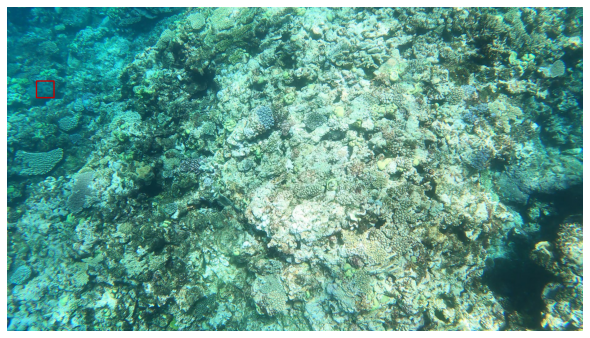

In [70]:
print('********************* #Before Preprocessing# *************************')
images_batch_for_animations=subsample_boxed_images('./working/data_dir/yolo/images_all',5,False,False)
vis_list=[]
for index,each_batch in enumerate(images_batch_for_animations):
    vis_list=vis_list+each_batch
HTML(plot_images(vis_list).to_html5_video())

********************* #After Preprocessing# *************************
Loading from cache list
Images from Preprocessed dir  True
Sample Image and video


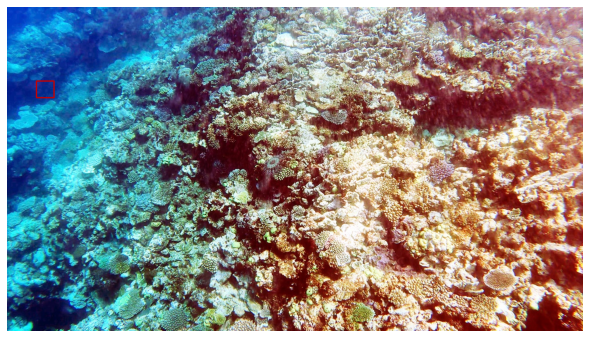

In [71]:
print('********************* #After Preprocessing# *************************')
images_batch_for_animations=subsample_boxed_images(path_yolo_images_preprocessed,12,True,True)
vis_list=[]
for index,each_batch in enumerate(images_batch_for_animations):
    vis_list=vis_list+each_batch
HTML(plot_images(vis_list).to_html5_video())

**Image preprocessing**

In [73]:
%cd working/data_dir/

D:\deep_learning\kaggle_barrier_reef_starfish_detection\working\data_dir


In [74]:
#%cd working/data_dir
#!git clone https://github.com/ultralytics/yolov5

In [75]:
%cd yolov5
#!pip install -r requirements.txt

D:\deep_learning\kaggle_barrier_reef_starfish_detection\working\data_dir\yolov5


In [76]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [77]:
import yaml 
# Can contain txt too but I wanted segregated images    
dict_file={
    "path": "../yolo",
    "train": "images/train",
    "val": "images/val",
    "nc":1,
    "names":['starfish']}
with open(r'./data/custom_yolo.yaml', 'w') as file:
    documents = yaml.dump(dict_file, file)
    

In [78]:
#Custom Hyperparameters (Fine-Tuning)

import os
import yaml

cwd = r'./data/custom_yolo_hyp.yaml'

data = hyperparams = {'lr0': 0.01,
 'lrf': 0.1, 
 'momentum': 0.937,  
 'weight_decay': 0.0005,
 'warmup_epochs': 5.0, #3.0
 'warmup_momentum': 0.8, #0.8
 'warmup_bias_lr': 0.1, #0.1
 'box': 0.05,
 'cls': 0.5, #0.5
 'cls_pw': 1.0,
 'obj': 1.0,
 'obj_pw': 1.0,
 'iou_t': 0.2,
 'anchor_t': 4.0,
 'fl_gamma': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,#0.7
 'hsv_v': 0.3,#0.3
 'degrees': 0.0,
 'translate': 0.1,
 'scale': 0.7, #0.5
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.5,
 'mosaic': 0.5, #1.0 # 0.0 was better
 'mixup': 0.5, #0.0
 'copy_paste': 0.0}

with open(os.path.join( cwd ), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd ), 'r')
print('\nyaml:')
print(f.read())


yaml:
anchor_t: 4.0
box: 0.05
cls: 0.5
cls_pw: 1.0
copy_paste: 0.0
degrees: 0.0
fl_gamma: 0.0
fliplr: 0.5
flipud: 0.0
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.3
iou_t: 0.2
lr0: 0.01
lrf: 0.1
mixup: 0.5
momentum: 0.937
mosaic: 0.5
obj: 1.0
obj_pw: 1.0
perspective: 0.0
scale: 0.7
shear: 0.0
translate: 0.1
warmup_bias_lr: 0.1
warmup_epochs: 5.0
warmup_momentum: 0.8
weight_decay: 0.0005



In [54]:
#Login to wandb to visaulise
#!pip install  wandb


In [55]:
#from kaggle_secrets import UserSecretsClient
import wandb
#user_secrets = UserSecretsClient()


In [56]:
#wandb_api = user_secrets.get_secret("wandb_yolo") 
#wandb.login(key=wandb_api)
wandb.login()

wandb: Currently logged in as: manasjoshi (use `wandb login --relogin` to force relogin)


True

In [57]:
!ls 

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [58]:
#--weights yolov5s.pt --cfg ./models/yolov5s.yaml

In [59]:
#!python train.py --img 640 --batch 15 --epochs 40 --data ./data/custom_yolo.yaml --weights yolov5m.pt --workers 0 --project kaggle_great_barrier_reef_ds_split --save-period 2